# Previsions of UK 

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

from scipy import optimize
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

In [2]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,989,998,1004,1029,1050,1076,1099,1122,1137,1143
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,763,763,763,763,764,764,764,765
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,61,69,70,70,71,74,81,84,86,86


In [3]:
## group by country, sum and transpose
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["United Kingdom"].values, columns=["total"])
## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [4]:
dtf.tail()

,total,new
2020-05-28,270508,1889.0
2020-05-29,272607,2099.0
2020-05-30,274219,1612.0
2020-05-31,276156,1937.0
2020-06-01,277736,1580.0


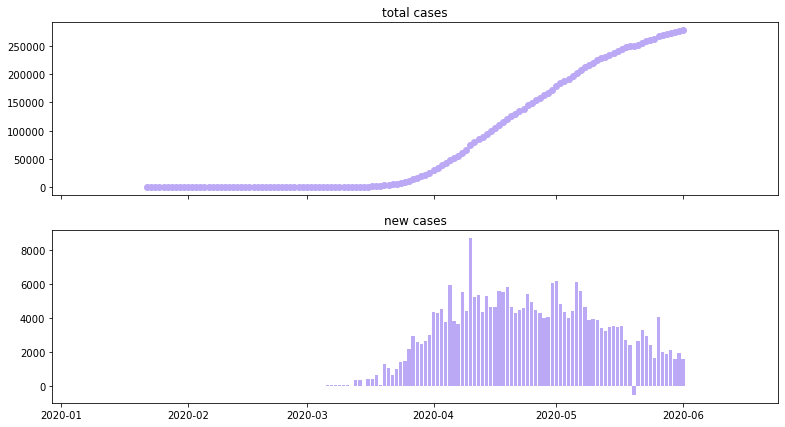

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="#BCA9F5")
ax[0].set(title="total cases")
ax[1].bar(dtf.index, dtf["new"].values, color="#BCA9F5")
ax[1].set(title="new cases")
plt.show()


In [6]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 500*x

y_linear = f(x=np.arange(len(dtf)))
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 100 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

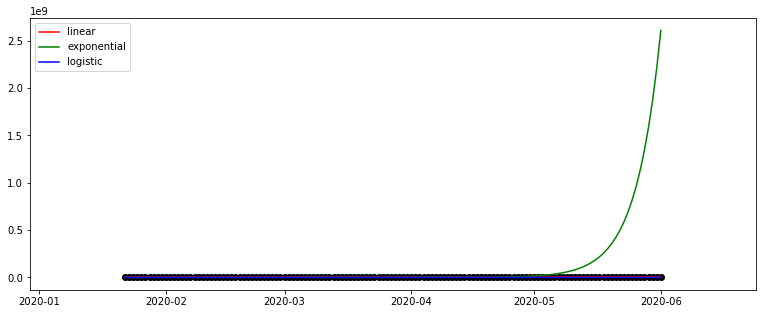

In [7]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [8]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 7000 * np.exp(-1.5 * ((x-90)/40)**2)
   

y_gaussian = f(x=np.arange(len(dtf)))

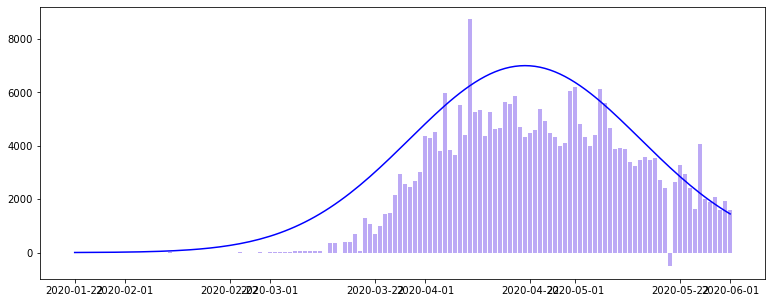

In [17]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="#BCA9F5")
ax.plot(dtf["new"].index, y_gaussian, color="blue")

plt.savefig('Images/Curva_Gauss.jpg', bbox_inches='tight')

plt.show()

In [10]:
def f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

In [11]:
## Fit
model = fit_curve(X=np.arange(len(dtf["total"])), y=dtf["total"].values, f=f, p0=[np.max(dtf["total"]), 1, 1])
model

array([2.78085243e+05, 8.68331969e-02, 9.24356465e+01])

--- generating index date --> start: 2020-06-02 00:00:00 | end: 2020-06-30 00:00:00 | len: 29 ---


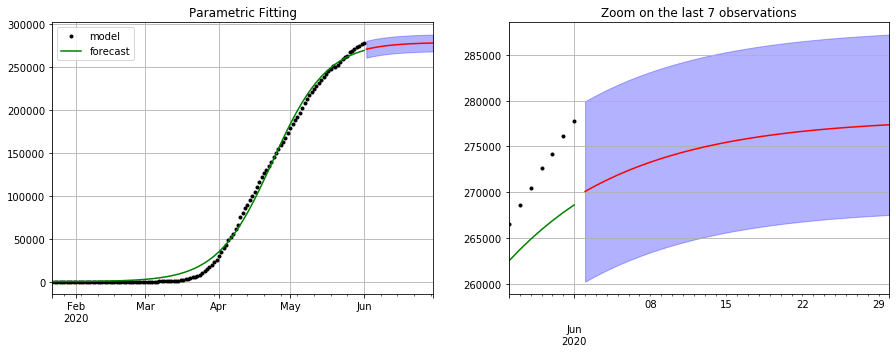

In [12]:
preds = forecast_curve(dtf["total"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

In [13]:
def f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

In [14]:
model = fit_curve(X=np.arange(len(dtf["new"])), y=dtf["new"].values, f=f, p0=[1, np.mean(dtf["new"]), np.std(dtf["new"])])
model

array([5474.74800915,   92.64763762,   21.43625336])

--- generating index date --> start: 2020-06-02 00:00:00 | end: 2020-06-30 00:00:00 | len: 29 ---


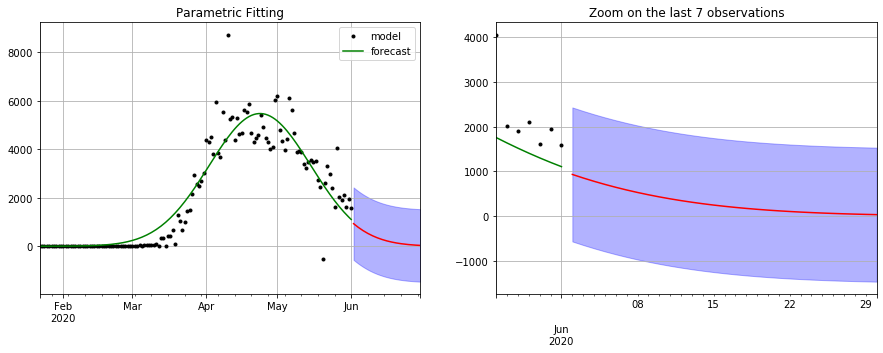

In [15]:
## Forecast
preds = forecast_curve(dtf["new"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))